In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import argparse
import pickle as pkl
import time
from copy import deepcopy

from tqdm import tqdm
import torch.optim.lr_scheduler as lr_scheduler
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from random import shuffle
from torch import nn
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn.functional as F
from torchvision.transforms import v2
torch.manual_seed(19)

c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback

In [2]:
transforms = v2.Compose([
    # v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomPerspective(0.4),
    v2.ToDtype(torch.float32)
])

class NCarsImageDataset(Dataset):
    def __init__(self, img_dir_file, transform=None, target_transform=None):
        self.images = np.load(img_dir_file + '_x.npy')
        self.labels = np.load(img_dir_file + '_y.npy')
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        # if self.transform:
        #     image = self.transform(image)
        # if self.target_transform:
        #     label = self.target_transform(label)
        label_temp = np.zeros((10,))
        label_temp[label] = 1
        if self.stage == 0:
            return self.transform(torch.tensor(image)), torch.tensor(label_temp)
        else:
            return torch.tensor(image), torch.tensor(label_temp)
    
    def set_stage(self, stage):
        self.stage = stage

In [3]:
from torch.utils.data import DataLoader
data = NCarsImageDataset("./Datasety/CIFAR10-DVS_128", transform=transforms)

generator1 = torch.Generator().manual_seed(42)
test_data, training_data = torch.utils.data.random_split(data, [0.3, 0.7], generator=generator1)

del data

In [4]:
train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, end_maxpool = False):
        super(ResidualBlock, self).__init__()
        if(downsample is not None):
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=False),
                            nn.MaxPool2d(kernel_size=2, stride=2)
                            )  # Changed inplace to False
        else:
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=False)
                            )
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU(inplace=False))  # Changed inplace to False
        self.downsample = downsample
        self.relu = nn.ReLU(inplace=False)  # Changed inplace to False
        self.out_channels = out_channels
        self.end_maxpool = end_maxpool

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out = out + residual
        if self.end_maxpool:
            out = F.relu(out, inplace=False)
        else:
            out = F.relu(out, inplace=False)   # Use non-in-place ReLU
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 2, in_channels = 5):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, 64, kernel_size = 7, stride = 1, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=False))
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2, end_maxpool = True)
        self.avgpool = nn.MaxPool2d(7, stride=1)
        self.fc = nn.Linear(2048, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1, end_maxpool = False):
        downsample = None
        if stride != 1 or self.inplanes != planes:

            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=1, padding='same'),
                nn.BatchNorm2d(planes),
                nn.ReLU(inplace=False),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            if i == blocks-1 and end_maxpool:
                layers.append(block(self.inplanes, planes, end_maxpool = True))
            else:
                layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.relu(x, inplace=False)
        x = self.fc2(x)
        return x
    
    def train_model(self, train_loader, valid_loader, num_epochs = 5, learning_rate=0.001, save_best = False, save_thr = 0.94):
        best_accuracy = 0.0
        total_step = len(train_loader)
        train_accuracy_h = []
        test_accuracy_h = []
        train_loss_h = []
        test_loss_h = []
        # Loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.RMSprop(self.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.96)#LinearLR(optimizer,  start_factor=start_factor, end_factor=end_factor, total_iters=total_iters)
        for epoch in range(num_epochs):
            # self.train()
            correct = 0
            total = 0
            running_loss = 0.0
            train_loader.dataset.dataset.set_stage(0)
            for i, (images, labels) in enumerate(tqdm(train_loader)):
                # Move tensors to the configured device
                images = images.float().to("cuda")
                labels = labels.type(torch.FloatTensor)
                labels = labels.to("cuda")


                optimizer.zero_grad()

                # Forward pass
                outputs = self.forward(images)
                loss = criterion(outputs, labels)
                # Backward and optimize
                loss.backward()
                
                optimizer.step()

                # accuracy
                _, predicted = torch.max(outputs.data, 1)
                correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
                total += labels.size(0)
                running_loss += loss.item()
                del images, labels, outputs
            train_accuracy_h.append((float(correct))/total)
            train_loss_h.append(running_loss/len(train_loader))
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}'
                            .format(epoch+1, num_epochs, i+1, total_step, running_loss/len(train_loader), (float(correct))/total))

            scheduler.step()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            # Validation
            with torch.no_grad():
                correct = 0
                total = 0
                val_loss = 0.0
                valid_loader.dataset.dataset.set_stage(1)
                for images, labels in valid_loader:
                    images = images.float().to("cuda")
                    labels = labels.type(torch.FloatTensor)
                    labels = labels.to("cuda")
                    outputs = self.forward(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    del images, labels, outputs
                if(((100 * correct / total) > best_accuracy) and save_best and ((100 * correct / total) > save_thr)):
                    torch.save(self.state_dict(), "best_resnet50_CIFAR10-DVS_ReLU_ReLUmaxpool__128x128_FC2_128x128_pretrained_aug_corrected_trilinear.pt")
                test_accuracy_h.append((float(correct))/total)
                test_loss_h.append(val_loss/len(valid_loader))
                print('Accuracy of the network: {} Loss: {}'.format( correct / total, val_loss/len(valid_loader)))
        return train_accuracy_h, test_accuracy_h, train_loss_h, test_loss_h

In [6]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()
model_resnet = ResNet(ResidualBlock, [3, 4, 6, 3], num_classes = 10, in_channels=6).to("cuda")
print(model_resnet)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(6, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (relu): ReLU()
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, mom

In [7]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)

Using cache found in C:\Users\nikos/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
size_layer = [3, 4, 6, 3]
layers = [(model_resnet.layer0, model.layer1), (model_resnet.layer1, model.layer2), (model_resnet.layer2, model.layer3), (model_resnet.layer3, model.layer4)]
for n in range(len(layers)):
    for i in range(size_layer[n]):
        layers[n][0][i].conv1[0] = layers[n][1][i].conv1
        layers[n][0][i].conv1[0].stride = 1
        layers[n][0][i].conv2[0] = layers[n][1][i].conv2
        layers[n][0][i].conv2[0].stride = 1
        
        layers[n][0][i].conv1[1] = layers[n][1][i].bn1
        layers[n][0][i].conv2[1] = layers[n][1][i].bn2

model_resnet.layer1[0].downsample[0] = model.layer2[0].downsample[0]
model_resnet.layer1[0].downsample[0].stride = 1
model_resnet.layer1[0].downsample[1] = model.layer2[0].downsample[1]

model_resnet.layer2[0].downsample[0] = model.layer3[0].downsample[0]
model_resnet.layer2[0].downsample[0].stride = 1
model_resnet.layer2[0].downsample[1] = model.layer3[0].downsample[1]

model_resnet.layer3[0].downsample[0] = model.layer4[0].downsample[0]
model_resnet.layer3[0].downsample[0].stride = 1
model_resnet.layer3[0].downsample[1] = model.layer4[0].downsample[1]

model_resnet.to("cuda")

ResNet(
  (conv1): Sequential(
    (0): Conv2d(6, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (relu): ReLU()
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=False)
        (1): Batch

In [9]:
torch.autograd.set_detect_anomaly(True)
train_accuracy_h, test_accuracy_h, train_loss_h, test_loss_h = model_resnet.train_model(train_dataloader, test_dataloader,num_epochs=300,save_best=True, save_thr=48)

100%|██████████| 219/219 [00:50<00:00,  4.30it/s]


Epoch [1/300], Step [219/219], Loss: 13.6418, Accuracy: 0.1123
Accuracy of the network: 0.11266666666666666 Loss: 2.7352269127013837


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [2/300], Step [219/219], Loss: 2.4349, Accuracy: 0.1421
Accuracy of the network: 0.18433333333333332 Loss: 2.222395847452448


100%|██████████| 219/219 [00:50<00:00,  4.30it/s]


Epoch [3/300], Step [219/219], Loss: 2.1870, Accuracy: 0.1634
Accuracy of the network: 0.186 Loss: 2.120445445496985


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [4/300], Step [219/219], Loss: 2.1648, Accuracy: 0.1631
Accuracy of the network: 0.19533333333333333 Loss: 2.1136264192297105


100%|██████████| 219/219 [00:50<00:00,  4.30it/s]


Epoch [5/300], Step [219/219], Loss: 2.1588, Accuracy: 0.1601
Accuracy of the network: 0.20633333333333334 Loss: 2.089821545367545


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [6/300], Step [219/219], Loss: 2.1392, Accuracy: 0.1751
Accuracy of the network: 0.161 Loss: 2.117920275698317


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [7/300], Step [219/219], Loss: 2.1303, Accuracy: 0.1709
Accuracy of the network: 0.19166666666666668 Loss: 2.0977884201293295


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [8/300], Step [219/219], Loss: 2.1174, Accuracy: 0.1880
Accuracy of the network: 0.171 Loss: 2.114306532322092


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [9/300], Step [219/219], Loss: 2.1173, Accuracy: 0.1826
Accuracy of the network: 0.198 Loss: 2.0883945683215526


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [10/300], Step [219/219], Loss: 2.1071, Accuracy: 0.1899
Accuracy of the network: 0.18733333333333332 Loss: 2.081331344361001


100%|██████████| 219/219 [00:50<00:00,  4.30it/s]


Epoch [11/300], Step [219/219], Loss: 2.1035, Accuracy: 0.1831
Accuracy of the network: 0.18966666666666668 Loss: 2.0666118720744517


100%|██████████| 219/219 [00:51<00:00,  4.28it/s]


Epoch [12/300], Step [219/219], Loss: 2.0994, Accuracy: 0.1963
Accuracy of the network: 0.20366666666666666 Loss: 2.084497293259235


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [13/300], Step [219/219], Loss: 2.0977, Accuracy: 0.1839
Accuracy of the network: 0.20233333333333334 Loss: 2.063179850578308


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [14/300], Step [219/219], Loss: 2.0861, Accuracy: 0.1970
Accuracy of the network: 0.19666666666666666 Loss: 2.067705897574729


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [15/300], Step [219/219], Loss: 2.0898, Accuracy: 0.1916
Accuracy of the network: 0.20966666666666667 Loss: 2.068418351893729


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [16/300], Step [219/219], Loss: 2.0821, Accuracy: 0.1924
Accuracy of the network: 0.18533333333333332 Loss: 2.064354295426227


100%|██████████| 219/219 [00:51<00:00,  4.27it/s]


Epoch [17/300], Step [219/219], Loss: 2.0835, Accuracy: 0.1950
Accuracy of the network: 0.18266666666666667 Loss: 2.130866415957187


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [18/300], Step [219/219], Loss: 2.0926, Accuracy: 0.1870
Accuracy of the network: 0.18666666666666668 Loss: 2.102756102034386


100%|██████████| 219/219 [00:50<00:00,  4.36it/s]


Epoch [19/300], Step [219/219], Loss: 2.0881, Accuracy: 0.1971
Accuracy of the network: 0.17333333333333334 Loss: 2.103372648675391


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [20/300], Step [219/219], Loss: 2.0817, Accuracy: 0.1891
Accuracy of the network: 0.211 Loss: 2.125140300456514


100%|██████████| 219/219 [00:50<00:00,  4.36it/s]


Epoch [21/300], Step [219/219], Loss: 2.0655, Accuracy: 0.2034
Accuracy of the network: 0.20533333333333334 Loss: 2.03922815398967


100%|██████████| 219/219 [00:50<00:00,  4.35it/s]


Epoch [22/300], Step [219/219], Loss: 2.0610, Accuracy: 0.2064
Accuracy of the network: 0.20833333333333334 Loss: 2.0709198117256165


100%|██████████| 219/219 [00:50<00:00,  4.36it/s]


Epoch [23/300], Step [219/219], Loss: 2.0567, Accuracy: 0.1980
Accuracy of the network: 0.21866666666666668 Loss: 2.047465735293449


100%|██████████| 219/219 [00:50<00:00,  4.37it/s]


Epoch [24/300], Step [219/219], Loss: 2.0618, Accuracy: 0.2030
Accuracy of the network: 0.21066666666666667 Loss: 2.0282271415629287


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [25/300], Step [219/219], Loss: 2.0566, Accuracy: 0.2019
Accuracy of the network: 0.20766666666666667 Loss: 2.0491984461216215


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [26/300], Step [219/219], Loss: 2.0457, Accuracy: 0.2199
Accuracy of the network: 0.23433333333333334 Loss: 2.043032405224252


100%|██████████| 219/219 [00:50<00:00,  4.36it/s]


Epoch [27/300], Step [219/219], Loss: 2.0245, Accuracy: 0.2211
Accuracy of the network: 0.232 Loss: 2.0422432283137706


100%|██████████| 219/219 [00:50<00:00,  4.35it/s]


Epoch [28/300], Step [219/219], Loss: 1.9952, Accuracy: 0.2410
Accuracy of the network: 0.2673333333333333 Loss: 1.954743651633567


100%|██████████| 219/219 [00:50<00:00,  4.37it/s]


Epoch [29/300], Step [219/219], Loss: 1.9773, Accuracy: 0.2540
Accuracy of the network: 0.25633333333333336 Loss: 1.972983111726477


100%|██████████| 219/219 [00:50<00:00,  4.36it/s]


Epoch [30/300], Step [219/219], Loss: 1.9630, Accuracy: 0.2529
Accuracy of the network: 0.25033333333333335 Loss: 1.941397083566544


100%|██████████| 219/219 [00:50<00:00,  4.36it/s]


Epoch [31/300], Step [219/219], Loss: 1.9434, Accuracy: 0.2629
Accuracy of the network: 0.2633333333333333 Loss: 1.9435471093400996


100%|██████████| 219/219 [00:50<00:00,  4.36it/s]


Epoch [32/300], Step [219/219], Loss: 1.9192, Accuracy: 0.2737
Accuracy of the network: 0.26666666666666666 Loss: 1.9430078547051612


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [33/300], Step [219/219], Loss: 1.9173, Accuracy: 0.2771
Accuracy of the network: 0.275 Loss: 1.9204250840430563


100%|██████████| 219/219 [00:50<00:00,  4.35it/s]


Epoch [34/300], Step [219/219], Loss: 1.9013, Accuracy: 0.2874
Accuracy of the network: 0.2996666666666667 Loss: 1.8846168467339048


100%|██████████| 219/219 [00:50<00:00,  4.38it/s]


Epoch [35/300], Step [219/219], Loss: 1.8830, Accuracy: 0.2926
Accuracy of the network: 0.30333333333333334 Loss: 1.8707703986066453


100%|██████████| 219/219 [00:50<00:00,  4.35it/s]


Epoch [36/300], Step [219/219], Loss: 1.8788, Accuracy: 0.3019
Accuracy of the network: 0.30433333333333334 Loss: 1.8590683062025841


100%|██████████| 219/219 [00:50<00:00,  4.38it/s]


Epoch [37/300], Step [219/219], Loss: 1.8515, Accuracy: 0.3121
Accuracy of the network: 0.31833333333333336 Loss: 1.8448991927694767


100%|██████████| 219/219 [00:50<00:00,  4.37it/s]


Epoch [38/300], Step [219/219], Loss: 1.8426, Accuracy: 0.3131
Accuracy of the network: 0.308 Loss: 1.854280077396555


100%|██████████| 219/219 [00:50<00:00,  4.36it/s]


Epoch [39/300], Step [219/219], Loss: 1.8250, Accuracy: 0.3274
Accuracy of the network: 0.32266666666666666 Loss: 1.840758502483368


100%|██████████| 219/219 [00:50<00:00,  4.36it/s]


Epoch [40/300], Step [219/219], Loss: 1.8136, Accuracy: 0.3250
Accuracy of the network: 0.291 Loss: 1.9110308695346752


100%|██████████| 219/219 [00:50<00:00,  4.35it/s]


Epoch [41/300], Step [219/219], Loss: 1.8186, Accuracy: 0.3220
Accuracy of the network: 0.32666666666666666 Loss: 1.811069482184471


100%|██████████| 219/219 [00:50<00:00,  4.37it/s]


Epoch [42/300], Step [219/219], Loss: 1.7948, Accuracy: 0.3331
Accuracy of the network: 0.33566666666666667 Loss: 1.8019016917715682


100%|██████████| 219/219 [00:50<00:00,  4.37it/s]


Epoch [43/300], Step [219/219], Loss: 1.7900, Accuracy: 0.3327
Accuracy of the network: 0.329 Loss: 1.8041037803000592


100%|██████████| 219/219 [00:50<00:00,  4.37it/s]


Epoch [44/300], Step [219/219], Loss: 1.7752, Accuracy: 0.3389
Accuracy of the network: 0.33 Loss: 1.8153129093190457


100%|██████████| 219/219 [00:50<00:00,  4.35it/s]


Epoch [45/300], Step [219/219], Loss: 1.7571, Accuracy: 0.3499
Accuracy of the network: 0.334 Loss: 1.8236150437213006


100%|██████████| 219/219 [00:50<00:00,  4.35it/s]


Epoch [46/300], Step [219/219], Loss: 1.7678, Accuracy: 0.3457
Accuracy of the network: 0.338 Loss: 1.8026455666156525


100%|██████████| 219/219 [00:50<00:00,  4.35it/s]


Epoch [47/300], Step [219/219], Loss: 1.7599, Accuracy: 0.3456
Accuracy of the network: 0.33466666666666667 Loss: 1.7936974611688168


100%|██████████| 219/219 [00:50<00:00,  4.37it/s]


Epoch [48/300], Step [219/219], Loss: 1.7462, Accuracy: 0.3534
Accuracy of the network: 0.3406666666666667 Loss: 1.760842134343817


100%|██████████| 219/219 [00:50<00:00,  4.37it/s]


Epoch [49/300], Step [219/219], Loss: 1.7429, Accuracy: 0.3487
Accuracy of the network: 0.35433333333333333 Loss: 1.7722996194311913


100%|██████████| 219/219 [00:50<00:00,  4.36it/s]


Epoch [50/300], Step [219/219], Loss: 1.7256, Accuracy: 0.3639
Accuracy of the network: 0.344 Loss: 1.7562133416216423


100%|██████████| 219/219 [00:50<00:00,  4.35it/s]


Epoch [51/300], Step [219/219], Loss: 1.7240, Accuracy: 0.3626
Accuracy of the network: 0.358 Loss: 1.750401461378057


100%|██████████| 219/219 [00:50<00:00,  4.37it/s]


Epoch [52/300], Step [219/219], Loss: 1.7293, Accuracy: 0.3544
Accuracy of the network: 0.359 Loss: 1.7538702285036127


100%|██████████| 219/219 [00:50<00:00,  4.37it/s]


Epoch [53/300], Step [219/219], Loss: 1.7034, Accuracy: 0.3677
Accuracy of the network: 0.367 Loss: 1.7289147250195767


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [54/300], Step [219/219], Loss: 1.6930, Accuracy: 0.3700
Accuracy of the network: 0.3626666666666667 Loss: 1.7314255541943488


100%|██████████| 219/219 [00:50<00:00,  4.37it/s]


Epoch [55/300], Step [219/219], Loss: 1.6959, Accuracy: 0.3709
Accuracy of the network: 0.36733333333333335 Loss: 1.7190700820151796


100%|██████████| 219/219 [00:50<00:00,  4.37it/s]


Epoch [56/300], Step [219/219], Loss: 1.6850, Accuracy: 0.3800
Accuracy of the network: 0.36566666666666664 Loss: 1.7251592240435012


100%|██████████| 219/219 [00:50<00:00,  4.38it/s]


Epoch [57/300], Step [219/219], Loss: 1.6678, Accuracy: 0.3834
Accuracy of the network: 0.367 Loss: 1.7137799503955435


100%|██████████| 219/219 [00:50<00:00,  4.36it/s]


Epoch [58/300], Step [219/219], Loss: 1.6741, Accuracy: 0.3831
Accuracy of the network: 0.37633333333333335 Loss: 1.696745103978096


100%|██████████| 219/219 [00:50<00:00,  4.36it/s]


Epoch [59/300], Step [219/219], Loss: 1.6577, Accuracy: 0.3840
Accuracy of the network: 0.362 Loss: 1.7241845980603645


100%|██████████| 219/219 [00:50<00:00,  4.37it/s]


Epoch [60/300], Step [219/219], Loss: 1.6508, Accuracy: 0.3896
Accuracy of the network: 0.37333333333333335 Loss: 1.7048241255131173


100%|██████████| 219/219 [00:50<00:00,  4.37it/s]


Epoch [61/300], Step [219/219], Loss: 1.6366, Accuracy: 0.3949
Accuracy of the network: 0.392 Loss: 1.6826344386060188


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [62/300], Step [219/219], Loss: 1.6417, Accuracy: 0.3924
Accuracy of the network: 0.379 Loss: 1.6951372953171426


100%|██████████| 219/219 [00:50<00:00,  4.35it/s]


Epoch [63/300], Step [219/219], Loss: 1.6449, Accuracy: 0.3881
Accuracy of the network: 0.38666666666666666 Loss: 1.6736845982835649


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [64/300], Step [219/219], Loss: 1.6312, Accuracy: 0.3964
Accuracy of the network: 0.38466666666666666 Loss: 1.6833459392507026


100%|██████████| 219/219 [00:50<00:00,  4.36it/s]


Epoch [65/300], Step [219/219], Loss: 1.6313, Accuracy: 0.3947
Accuracy of the network: 0.393 Loss: 1.6657979399599927


100%|██████████| 219/219 [00:50<00:00,  4.35it/s]


Epoch [66/300], Step [219/219], Loss: 1.6217, Accuracy: 0.4057
Accuracy of the network: 0.387 Loss: 1.684715859433438


100%|██████████| 219/219 [00:50<00:00,  4.35it/s]


Epoch [67/300], Step [219/219], Loss: 1.6229, Accuracy: 0.3944
Accuracy of the network: 0.3863333333333333 Loss: 1.673250751292452


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [68/300], Step [219/219], Loss: 1.6091, Accuracy: 0.4017
Accuracy of the network: 0.40166666666666667 Loss: 1.6599985272326367


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [69/300], Step [219/219], Loss: 1.5989, Accuracy: 0.4090
Accuracy of the network: 0.39466666666666667 Loss: 1.675273006266736


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [70/300], Step [219/219], Loss: 1.5902, Accuracy: 0.4090
Accuracy of the network: 0.39266666666666666 Loss: 1.643886888280828


100%|██████████| 219/219 [00:50<00:00,  4.36it/s]


Epoch [71/300], Step [219/219], Loss: 1.5904, Accuracy: 0.4069
Accuracy of the network: 0.38866666666666666 Loss: 1.6772882811566616


100%|██████████| 219/219 [00:50<00:00,  4.35it/s]


Epoch [72/300], Step [219/219], Loss: 1.5761, Accuracy: 0.4126
Accuracy of the network: 0.4026666666666667 Loss: 1.6369294093010274


100%|██████████| 219/219 [00:50<00:00,  4.36it/s]


Epoch [73/300], Step [219/219], Loss: 1.5700, Accuracy: 0.4181
Accuracy of the network: 0.3913333333333333 Loss: 1.657339206401338


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [74/300], Step [219/219], Loss: 1.5714, Accuracy: 0.4150
Accuracy of the network: 0.4043333333333333 Loss: 1.6275258850544057


100%|██████████| 219/219 [00:50<00:00,  4.36it/s]


Epoch [75/300], Step [219/219], Loss: 1.5591, Accuracy: 0.4253
Accuracy of the network: 0.4003333333333333 Loss: 1.6479350150899683


100%|██████████| 219/219 [00:50<00:00,  4.36it/s]


Epoch [76/300], Step [219/219], Loss: 1.5617, Accuracy: 0.4253
Accuracy of the network: 0.41233333333333333 Loss: 1.6261922070320616


100%|██████████| 219/219 [00:50<00:00,  4.37it/s]


Epoch [77/300], Step [219/219], Loss: 1.5462, Accuracy: 0.4311
Accuracy of the network: 0.4046666666666667 Loss: 1.6131928093889927


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [78/300], Step [219/219], Loss: 1.5345, Accuracy: 0.4340
Accuracy of the network: 0.4026666666666667 Loss: 1.6234522829664515


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [79/300], Step [219/219], Loss: 1.5329, Accuracy: 0.4317
Accuracy of the network: 0.39866666666666667 Loss: 1.6425006009162741


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [80/300], Step [219/219], Loss: 1.5169, Accuracy: 0.4409
Accuracy of the network: 0.4073333333333333 Loss: 1.6097338465934103


100%|██████████| 219/219 [00:50<00:00,  4.35it/s]


Epoch [81/300], Step [219/219], Loss: 1.5164, Accuracy: 0.4457
Accuracy of the network: 0.4063333333333333 Loss: 1.6164460144144424


100%|██████████| 219/219 [00:50<00:00,  4.35it/s]


Epoch [82/300], Step [219/219], Loss: 1.5062, Accuracy: 0.4527
Accuracy of the network: 0.4073333333333333 Loss: 1.6030342502796904


100%|██████████| 219/219 [00:50<00:00,  4.38it/s]


Epoch [83/300], Step [219/219], Loss: 1.5051, Accuracy: 0.4523
Accuracy of the network: 0.4216666666666667 Loss: 1.6033630485230304


100%|██████████| 219/219 [00:50<00:00,  4.35it/s]


Epoch [84/300], Step [219/219], Loss: 1.4932, Accuracy: 0.4506
Accuracy of the network: 0.4096666666666667 Loss: 1.6126301187150023


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [85/300], Step [219/219], Loss: 1.4962, Accuracy: 0.4506
Accuracy of the network: 0.4216666666666667 Loss: 1.5852573082802144


100%|██████████| 219/219 [00:50<00:00,  4.35it/s]


Epoch [86/300], Step [219/219], Loss: 1.4831, Accuracy: 0.4541
Accuracy of the network: 0.4256666666666667 Loss: 1.5850308334573786


100%|██████████| 219/219 [00:50<00:00,  4.36it/s]


Epoch [87/300], Step [219/219], Loss: 1.4796, Accuracy: 0.4563
Accuracy of the network: 0.42533333333333334 Loss: 1.5821556930846357


100%|██████████| 219/219 [00:50<00:00,  4.35it/s]


Epoch [88/300], Step [219/219], Loss: 1.4661, Accuracy: 0.4701
Accuracy of the network: 0.4246666666666667 Loss: 1.5694681063611458


100%|██████████| 219/219 [00:52<00:00,  4.17it/s]


Epoch [89/300], Step [219/219], Loss: 1.4611, Accuracy: 0.4671
Accuracy of the network: 0.438 Loss: 1.5723469498309683


100%|██████████| 219/219 [00:55<00:00,  3.91it/s]


Epoch [90/300], Step [219/219], Loss: 1.4377, Accuracy: 0.4746
Accuracy of the network: 0.43633333333333335 Loss: 1.5457217338237357


100%|██████████| 219/219 [00:57<00:00,  3.81it/s]


Epoch [91/300], Step [219/219], Loss: 1.4491, Accuracy: 0.4684
Accuracy of the network: 0.445 Loss: 1.5556719265085586


100%|██████████| 219/219 [00:57<00:00,  3.83it/s]


Epoch [92/300], Step [219/219], Loss: 1.4398, Accuracy: 0.4781
Accuracy of the network: 0.4533333333333333 Loss: 1.5433314987953672


100%|██████████| 219/219 [00:55<00:00,  3.98it/s]


Epoch [93/300], Step [219/219], Loss: 1.4218, Accuracy: 0.4796
Accuracy of the network: 0.44733333333333336 Loss: 1.550125464479974


100%|██████████| 219/219 [00:51<00:00,  4.22it/s]


Epoch [94/300], Step [219/219], Loss: 1.4086, Accuracy: 0.4903
Accuracy of the network: 0.452 Loss: 1.551903894607057


100%|██████████| 219/219 [00:52<00:00,  4.17it/s]


Epoch [95/300], Step [219/219], Loss: 1.4146, Accuracy: 0.4947
Accuracy of the network: 0.445 Loss: 1.5383502777586593


100%|██████████| 219/219 [00:52<00:00,  4.19it/s]


Epoch [96/300], Step [219/219], Loss: 1.3974, Accuracy: 0.4933
Accuracy of the network: 0.43866666666666665 Loss: 1.5512438074071357


100%|██████████| 219/219 [00:52<00:00,  4.16it/s]


Epoch [97/300], Step [219/219], Loss: 1.3881, Accuracy: 0.4994
Accuracy of the network: 0.43833333333333335 Loss: 1.5572007564788168


100%|██████████| 219/219 [00:51<00:00,  4.23it/s]


Epoch [98/300], Step [219/219], Loss: 1.3800, Accuracy: 0.5030
Accuracy of the network: 0.44366666666666665 Loss: 1.5311797375374652


100%|██████████| 219/219 [00:52<00:00,  4.20it/s]


Epoch [99/300], Step [219/219], Loss: 1.3733, Accuracy: 0.5093
Accuracy of the network: 0.449 Loss: 1.5134797945935676


100%|██████████| 219/219 [00:52<00:00,  4.19it/s]


Epoch [100/300], Step [219/219], Loss: 1.3718, Accuracy: 0.5069
Accuracy of the network: 0.45 Loss: 1.5345697200044672


100%|██████████| 219/219 [00:51<00:00,  4.24it/s]


Epoch [101/300], Step [219/219], Loss: 1.3748, Accuracy: 0.4993
Accuracy of the network: 0.4573333333333333 Loss: 1.5266992449760437


100%|██████████| 219/219 [00:51<00:00,  4.24it/s]


Epoch [102/300], Step [219/219], Loss: 1.3538, Accuracy: 0.5173
Accuracy of the network: 0.44166666666666665 Loss: 1.5523143131682213


100%|██████████| 219/219 [00:52<00:00,  4.18it/s]


Epoch [103/300], Step [219/219], Loss: 1.3544, Accuracy: 0.5131
Accuracy of the network: 0.45366666666666666 Loss: 1.514335593010517


100%|██████████| 219/219 [00:51<00:00,  4.22it/s]


Epoch [104/300], Step [219/219], Loss: 1.3539, Accuracy: 0.5153
Accuracy of the network: 0.454 Loss: 1.509103761074391


100%|██████████| 219/219 [00:53<00:00,  4.12it/s]


Epoch [105/300], Step [219/219], Loss: 1.3416, Accuracy: 0.5281
Accuracy of the network: 0.447 Loss: 1.5159622532256105


100%|██████████| 219/219 [00:53<00:00,  4.10it/s]


Epoch [106/300], Step [219/219], Loss: 1.3451, Accuracy: 0.5197
Accuracy of the network: 0.45366666666666666 Loss: 1.5124142296770786


100%|██████████| 219/219 [00:53<00:00,  4.12it/s]


Epoch [107/300], Step [219/219], Loss: 1.3354, Accuracy: 0.5260
Accuracy of the network: 0.46166666666666667 Loss: 1.5076039547615863


100%|██████████| 219/219 [00:52<00:00,  4.15it/s]


Epoch [108/300], Step [219/219], Loss: 1.3353, Accuracy: 0.5203
Accuracy of the network: 0.45466666666666666 Loss: 1.502090961375135


100%|██████████| 219/219 [00:52<00:00,  4.18it/s]


Epoch [109/300], Step [219/219], Loss: 1.3232, Accuracy: 0.5273
Accuracy of the network: 0.4553333333333333 Loss: 1.5083770219315873


100%|██████████| 219/219 [00:53<00:00,  4.08it/s]


Epoch [110/300], Step [219/219], Loss: 1.3116, Accuracy: 0.5284
Accuracy of the network: 0.455 Loss: 1.5194519365087469


100%|██████████| 219/219 [00:54<00:00,  4.00it/s]


Epoch [111/300], Step [219/219], Loss: 1.3057, Accuracy: 0.5317
Accuracy of the network: 0.4563333333333333 Loss: 1.5025973472189396


100%|██████████| 219/219 [00:54<00:00,  4.00it/s]


Epoch [112/300], Step [219/219], Loss: 1.3063, Accuracy: 0.5301
Accuracy of the network: 0.4663333333333333 Loss: 1.5035811421719003


100%|██████████| 219/219 [00:54<00:00,  4.03it/s]


Epoch [113/300], Step [219/219], Loss: 1.2918, Accuracy: 0.5374
Accuracy of the network: 0.4686666666666667 Loss: 1.4875881189995623


100%|██████████| 219/219 [00:52<00:00,  4.19it/s]


Epoch [114/300], Step [219/219], Loss: 1.3036, Accuracy: 0.5317
Accuracy of the network: 0.45966666666666667 Loss: 1.4975617667461962


100%|██████████| 219/219 [00:53<00:00,  4.11it/s]


Epoch [115/300], Step [219/219], Loss: 1.2967, Accuracy: 0.5393
Accuracy of the network: 0.466 Loss: 1.5010344411464447


100%|██████████| 219/219 [00:53<00:00,  4.12it/s]


Epoch [116/300], Step [219/219], Loss: 1.2968, Accuracy: 0.5367
Accuracy of the network: 0.466 Loss: 1.4935640749779153


100%|██████████| 219/219 [00:52<00:00,  4.19it/s]


Epoch [117/300], Step [219/219], Loss: 1.2866, Accuracy: 0.5416
Accuracy of the network: 0.4633333333333333 Loss: 1.487684502246532


100%|██████████| 219/219 [00:52<00:00,  4.17it/s]


Epoch [118/300], Step [219/219], Loss: 1.2748, Accuracy: 0.5464
Accuracy of the network: 0.473 Loss: 1.4872410963190363


100%|██████████| 219/219 [00:52<00:00,  4.18it/s]


Epoch [119/300], Step [219/219], Loss: 1.2661, Accuracy: 0.5484
Accuracy of the network: 0.46266666666666667 Loss: 1.4975286100773102


100%|██████████| 219/219 [00:52<00:00,  4.16it/s]


Epoch [120/300], Step [219/219], Loss: 1.2619, Accuracy: 0.5484
Accuracy of the network: 0.463 Loss: 1.4827638198720647


100%|██████████| 219/219 [00:52<00:00,  4.19it/s]


Epoch [121/300], Step [219/219], Loss: 1.2641, Accuracy: 0.5496
Accuracy of the network: 0.4663333333333333 Loss: 1.4847090929112536


100%|██████████| 219/219 [00:52<00:00,  4.20it/s]


Epoch [122/300], Step [219/219], Loss: 1.2625, Accuracy: 0.5490
Accuracy of the network: 0.479 Loss: 1.4795323090350374


100%|██████████| 219/219 [00:52<00:00,  4.19it/s]


Epoch [123/300], Step [219/219], Loss: 1.2491, Accuracy: 0.5604
Accuracy of the network: 0.476 Loss: 1.485786332094923


100%|██████████| 219/219 [00:52<00:00,  4.18it/s]


Epoch [124/300], Step [219/219], Loss: 1.2545, Accuracy: 0.5531
Accuracy of the network: 0.4663333333333333 Loss: 1.474325382329048


100%|██████████| 219/219 [00:52<00:00,  4.19it/s]


Epoch [125/300], Step [219/219], Loss: 1.2453, Accuracy: 0.5620
Accuracy of the network: 0.4696666666666667 Loss: 1.4771665550292807


100%|██████████| 219/219 [00:52<00:00,  4.17it/s]


Epoch [126/300], Step [219/219], Loss: 1.2401, Accuracy: 0.5573
Accuracy of the network: 0.4776666666666667 Loss: 1.4777421228429104


100%|██████████| 219/219 [00:52<00:00,  4.18it/s]


Epoch [127/300], Step [219/219], Loss: 1.2434, Accuracy: 0.5529
Accuracy of the network: 0.479 Loss: 1.4633417763608567


100%|██████████| 219/219 [00:52<00:00,  4.17it/s]


Epoch [128/300], Step [219/219], Loss: 1.2356, Accuracy: 0.5617
Accuracy of the network: 0.481 Loss: 1.4740657996624074


100%|██████████| 219/219 [00:52<00:00,  4.14it/s]


Epoch [129/300], Step [219/219], Loss: 1.2307, Accuracy: 0.5673
Accuracy of the network: 0.48533333333333334 Loss: 1.4671690476701615


100%|██████████| 219/219 [00:52<00:00,  4.20it/s]


Epoch [130/300], Step [219/219], Loss: 1.2182, Accuracy: 0.5609
Accuracy of the network: 0.474 Loss: 1.4724977117903688


100%|██████████| 219/219 [00:51<00:00,  4.28it/s]


Epoch [131/300], Step [219/219], Loss: 1.2235, Accuracy: 0.5647
Accuracy of the network: 0.468 Loss: 1.4814966130763927


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [132/300], Step [219/219], Loss: 1.2079, Accuracy: 0.5683
Accuracy of the network: 0.48 Loss: 1.489838312915031


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [133/300], Step [219/219], Loss: 1.2129, Accuracy: 0.5670
Accuracy of the network: 0.476 Loss: 1.4676521261955828


100%|██████████| 219/219 [00:50<00:00,  4.35it/s]


Epoch [134/300], Step [219/219], Loss: 1.2131, Accuracy: 0.5717
Accuracy of the network: 0.47633333333333333 Loss: 1.4809899837412732


100%|██████████| 219/219 [00:55<00:00,  3.94it/s]


Epoch [135/300], Step [219/219], Loss: 1.2109, Accuracy: 0.5674
Accuracy of the network: 0.48 Loss: 1.4717246370112642


100%|██████████| 219/219 [00:56<00:00,  3.91it/s]


Epoch [136/300], Step [219/219], Loss: 1.1923, Accuracy: 0.5786
Accuracy of the network: 0.4716666666666667 Loss: 1.4669707810625117


100%|██████████| 219/219 [00:55<00:00,  3.95it/s]


Epoch [137/300], Step [219/219], Loss: 1.2046, Accuracy: 0.5703
Accuracy of the network: 0.4693333333333333 Loss: 1.4748794081363272


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [138/300], Step [219/219], Loss: 1.1920, Accuracy: 0.5769
Accuracy of the network: 0.49 Loss: 1.4611266204651365


100%|██████████| 219/219 [00:50<00:00,  4.36it/s]


Epoch [139/300], Step [219/219], Loss: 1.1895, Accuracy: 0.5814
Accuracy of the network: 0.483 Loss: 1.4519544376971874


100%|██████████| 219/219 [00:51<00:00,  4.26it/s]


Epoch [140/300], Step [219/219], Loss: 1.1865, Accuracy: 0.5814
Accuracy of the network: 0.486 Loss: 1.4652332308444571


100%|██████████| 219/219 [00:56<00:00,  3.88it/s]


Epoch [141/300], Step [219/219], Loss: 1.1907, Accuracy: 0.5784
Accuracy of the network: 0.48 Loss: 1.4691468749908692


100%|██████████| 219/219 [00:56<00:00,  3.91it/s]


Epoch [142/300], Step [219/219], Loss: 1.1861, Accuracy: 0.5733
Accuracy of the network: 0.4786666666666667 Loss: 1.4664502175564462


100%|██████████| 219/219 [00:51<00:00,  4.23it/s]


Epoch [143/300], Step [219/219], Loss: 1.1847, Accuracy: 0.5804
Accuracy of the network: 0.49066666666666664 Loss: 1.4479092220042615


100%|██████████| 219/219 [00:51<00:00,  4.23it/s]


Epoch [144/300], Step [219/219], Loss: 1.1728, Accuracy: 0.5840
Accuracy of the network: 0.48333333333333334 Loss: 1.4727564466760514


100%|██████████| 219/219 [00:54<00:00,  4.04it/s]


Epoch [145/300], Step [219/219], Loss: 1.1619, Accuracy: 0.5884
Accuracy of the network: 0.486 Loss: 1.4510804985431915


100%|██████████| 219/219 [00:55<00:00,  3.96it/s]


Epoch [146/300], Step [219/219], Loss: 1.1631, Accuracy: 0.5880
Accuracy of the network: 0.48233333333333334 Loss: 1.4662592360313902


100%|██████████| 219/219 [00:51<00:00,  4.28it/s]


Epoch [147/300], Step [219/219], Loss: 1.1660, Accuracy: 0.5899
Accuracy of the network: 0.4816666666666667 Loss: 1.4578978977304824


100%|██████████| 219/219 [00:51<00:00,  4.26it/s]


Epoch [148/300], Step [219/219], Loss: 1.1701, Accuracy: 0.5891
Accuracy of the network: 0.4776666666666667 Loss: 1.4642370723663491


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [149/300], Step [219/219], Loss: 1.1544, Accuracy: 0.5910
Accuracy of the network: 0.4886666666666667 Loss: 1.459920290936815


100%|██████████| 219/219 [00:51<00:00,  4.28it/s]


Epoch [150/300], Step [219/219], Loss: 1.1605, Accuracy: 0.5821
Accuracy of the network: 0.4816666666666667 Loss: 1.4568704442774996


100%|██████████| 219/219 [00:51<00:00,  4.29it/s]


Epoch [151/300], Step [219/219], Loss: 1.1614, Accuracy: 0.5856
Accuracy of the network: 0.49 Loss: 1.4538360935576418


100%|██████████| 219/219 [00:51<00:00,  4.26it/s]


Epoch [152/300], Step [219/219], Loss: 1.1564, Accuracy: 0.5889
Accuracy of the network: 0.4856666666666667 Loss: 1.4644256031259577


100%|██████████| 219/219 [00:51<00:00,  4.27it/s]


Epoch [153/300], Step [219/219], Loss: 1.1493, Accuracy: 0.5881
Accuracy of the network: 0.49 Loss: 1.4549754496584548


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [154/300], Step [219/219], Loss: 1.1528, Accuracy: 0.5894
Accuracy of the network: 0.49033333333333334 Loss: 1.447919675644408


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [155/300], Step [219/219], Loss: 1.1415, Accuracy: 0.5924
Accuracy of the network: 0.484 Loss: 1.4633777718594734


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [156/300], Step [219/219], Loss: 1.1494, Accuracy: 0.5960
Accuracy of the network: 0.48966666666666664 Loss: 1.4500213493692113


100%|██████████| 219/219 [00:50<00:00,  4.36it/s]


Epoch [157/300], Step [219/219], Loss: 1.1298, Accuracy: 0.5991
Accuracy of the network: 0.48933333333333334 Loss: 1.4462076273370297


100%|██████████| 219/219 [00:50<00:00,  4.30it/s]


Epoch [158/300], Step [219/219], Loss: 1.1422, Accuracy: 0.5974
Accuracy of the network: 0.486 Loss: 1.4605315999781832


100%|██████████| 219/219 [00:50<00:00,  4.30it/s]


Epoch [159/300], Step [219/219], Loss: 1.1346, Accuracy: 0.5996
Accuracy of the network: 0.49666666666666665 Loss: 1.4419616042299475


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [160/300], Step [219/219], Loss: 1.1303, Accuracy: 0.6053
Accuracy of the network: 0.494 Loss: 1.4422355021568054


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [161/300], Step [219/219], Loss: 1.1296, Accuracy: 0.6017
Accuracy of the network: 0.49 Loss: 1.4446564475272565


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [162/300], Step [219/219], Loss: 1.1356, Accuracy: 0.5917
Accuracy of the network: 0.485 Loss: 1.4543297645893503


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [163/300], Step [219/219], Loss: 1.1230, Accuracy: 0.6087
Accuracy of the network: 0.49033333333333334 Loss: 1.4527452099830547


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [164/300], Step [219/219], Loss: 1.1202, Accuracy: 0.5991
Accuracy of the network: 0.485 Loss: 1.4504485846833979


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [165/300], Step [219/219], Loss: 1.1298, Accuracy: 0.6019
Accuracy of the network: 0.48733333333333334 Loss: 1.4572037604260952


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [166/300], Step [219/219], Loss: 1.1285, Accuracy: 0.6009
Accuracy of the network: 0.49466666666666664 Loss: 1.4489092421024403


100%|██████████| 219/219 [00:50<00:00,  4.35it/s]


Epoch [167/300], Step [219/219], Loss: 1.1256, Accuracy: 0.6040
Accuracy of the network: 0.49366666666666664 Loss: 1.4320954299987632


100%|██████████| 219/219 [00:50<00:00,  4.37it/s]


Epoch [168/300], Step [219/219], Loss: 1.1226, Accuracy: 0.6017
Accuracy of the network: 0.49366666666666664 Loss: 1.4463064924199531


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [169/300], Step [219/219], Loss: 1.1237, Accuracy: 0.5994
Accuracy of the network: 0.49633333333333335 Loss: 1.4362025235561615


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [170/300], Step [219/219], Loss: 1.1180, Accuracy: 0.6037
Accuracy of the network: 0.4886666666666667 Loss: 1.4478945453116234


100%|██████████| 219/219 [00:50<00:00,  4.35it/s]


Epoch [171/300], Step [219/219], Loss: 1.1250, Accuracy: 0.6041
Accuracy of the network: 0.491 Loss: 1.4396379285670342


100%|██████████| 219/219 [00:50<00:00,  4.36it/s]


Epoch [172/300], Step [219/219], Loss: 1.1069, Accuracy: 0.6060
Accuracy of the network: 0.48533333333333334 Loss: 1.4496779080401077


100%|██████████| 219/219 [00:51<00:00,  4.28it/s]


Epoch [173/300], Step [219/219], Loss: 1.1004, Accuracy: 0.6117
Accuracy of the network: 0.49433333333333335 Loss: 1.439299038115968


100%|██████████| 219/219 [00:50<00:00,  4.30it/s]


Epoch [174/300], Step [219/219], Loss: 1.0993, Accuracy: 0.6167
Accuracy of the network: 0.48966666666666664 Loss: 1.4527935290590246


100%|██████████| 219/219 [00:51<00:00,  4.26it/s]


Epoch [175/300], Step [219/219], Loss: 1.1098, Accuracy: 0.6056
Accuracy of the network: 0.495 Loss: 1.444524073220314


100%|██████████| 219/219 [00:52<00:00,  4.18it/s]


Epoch [176/300], Step [219/219], Loss: 1.1138, Accuracy: 0.6081
Accuracy of the network: 0.49466666666666664 Loss: 1.4388279737310206


100%|██████████| 219/219 [00:52<00:00,  4.21it/s]


Epoch [177/300], Step [219/219], Loss: 1.1199, Accuracy: 0.6083
Accuracy of the network: 0.49433333333333335 Loss: 1.4476993553181912


100%|██████████| 219/219 [00:51<00:00,  4.27it/s]


Epoch [178/300], Step [219/219], Loss: 1.1100, Accuracy: 0.6104
Accuracy of the network: 0.492 Loss: 1.4591790640607794


100%|██████████| 219/219 [00:51<00:00,  4.22it/s]


Epoch [179/300], Step [219/219], Loss: 1.1042, Accuracy: 0.6079
Accuracy of the network: 0.48966666666666664 Loss: 1.4488539366011923


100%|██████████| 219/219 [00:51<00:00,  4.22it/s]


Epoch [180/300], Step [219/219], Loss: 1.1122, Accuracy: 0.6053
Accuracy of the network: 0.496 Loss: 1.4402039786602587


100%|██████████| 219/219 [00:52<00:00,  4.21it/s]


Epoch [181/300], Step [219/219], Loss: 1.0983, Accuracy: 0.6159
Accuracy of the network: 0.49633333333333335 Loss: 1.4403697341046435


100%|██████████| 219/219 [00:51<00:00,  4.26it/s]


Epoch [182/300], Step [219/219], Loss: 1.1129, Accuracy: 0.6070
Accuracy of the network: 0.49133333333333334 Loss: 1.436105230387221


100%|██████████| 219/219 [00:51<00:00,  4.22it/s]


Epoch [183/300], Step [219/219], Loss: 1.1037, Accuracy: 0.6089
Accuracy of the network: 0.49533333333333335 Loss: 1.450935202710172


100%|██████████| 219/219 [00:51<00:00,  4.26it/s]


Epoch [184/300], Step [219/219], Loss: 1.0993, Accuracy: 0.6124
Accuracy of the network: 0.501 Loss: 1.437448095768056


100%|██████████| 219/219 [00:52<00:00,  4.20it/s]


Epoch [185/300], Step [219/219], Loss: 1.1062, Accuracy: 0.6076
Accuracy of the network: 0.497 Loss: 1.4412762643174921


100%|██████████| 219/219 [00:51<00:00,  4.21it/s]


Epoch [186/300], Step [219/219], Loss: 1.1089, Accuracy: 0.6113
Accuracy of the network: 0.49333333333333335 Loss: 1.436021496640875


100%|██████████| 219/219 [00:51<00:00,  4.22it/s]


Epoch [187/300], Step [219/219], Loss: 1.0935, Accuracy: 0.6181
Accuracy of the network: 0.501 Loss: 1.442864308331875


100%|██████████| 219/219 [00:51<00:00,  4.23it/s]


Epoch [188/300], Step [219/219], Loss: 1.0874, Accuracy: 0.6180
Accuracy of the network: 0.49333333333333335 Loss: 1.4504051011927583


100%|██████████| 219/219 [00:52<00:00,  4.19it/s]


Epoch [189/300], Step [219/219], Loss: 1.0911, Accuracy: 0.6164
Accuracy of the network: 0.5013333333333333 Loss: 1.4426962517677469


100%|██████████| 219/219 [00:51<00:00,  4.22it/s]


Epoch [190/300], Step [219/219], Loss: 1.0894, Accuracy: 0.6097
Accuracy of the network: 0.5003333333333333 Loss: 1.448728619103736


100%|██████████| 219/219 [00:52<00:00,  4.14it/s]


Epoch [191/300], Step [219/219], Loss: 1.0891, Accuracy: 0.6159
Accuracy of the network: 0.498 Loss: 1.4419592238487082


100%|██████████| 219/219 [00:50<00:00,  4.30it/s]


Epoch [192/300], Step [219/219], Loss: 1.0998, Accuracy: 0.6144
Accuracy of the network: 0.49266666666666664 Loss: 1.447319174066503


100%|██████████| 219/219 [00:50<00:00,  4.35it/s]


Epoch [193/300], Step [219/219], Loss: 1.0942, Accuracy: 0.6151
Accuracy of the network: 0.49166666666666664 Loss: 1.4422051209084532


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [194/300], Step [219/219], Loss: 1.1001, Accuracy: 0.6121
Accuracy of the network: 0.49366666666666664 Loss: 1.4427314375309235


100%|██████████| 219/219 [00:50<00:00,  4.37it/s]


Epoch [195/300], Step [219/219], Loss: 1.0955, Accuracy: 0.6059
Accuracy of the network: 0.48533333333333334 Loss: 1.4520261833008299


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [196/300], Step [219/219], Loss: 1.1077, Accuracy: 0.6059
Accuracy of the network: 0.5026666666666667 Loss: 1.437870830931562


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [197/300], Step [219/219], Loss: 1.1001, Accuracy: 0.6117
Accuracy of the network: 0.49533333333333335 Loss: 1.440308927221501


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [198/300], Step [219/219], Loss: 1.0924, Accuracy: 0.6140
Accuracy of the network: 0.499 Loss: 1.4359461145198091


100%|██████████| 219/219 [00:50<00:00,  4.35it/s]


Epoch [199/300], Step [219/219], Loss: 1.0887, Accuracy: 0.6177
Accuracy of the network: 0.489 Loss: 1.4454928940915046


100%|██████████| 219/219 [00:50<00:00,  4.38it/s]


Epoch [200/300], Step [219/219], Loss: 1.0944, Accuracy: 0.6137
Accuracy of the network: 0.48966666666666664 Loss: 1.4375745863356488


100%|██████████| 219/219 [00:51<00:00,  4.28it/s]


Epoch [201/300], Step [219/219], Loss: 1.0876, Accuracy: 0.6163
Accuracy of the network: 0.499 Loss: 1.4403632536847542


100%|██████████| 219/219 [00:51<00:00,  4.25it/s]


Epoch [202/300], Step [219/219], Loss: 1.0931, Accuracy: 0.6104
Accuracy of the network: 0.49733333333333335 Loss: 1.4472794577162316


100%|██████████| 219/219 [00:51<00:00,  4.27it/s]


Epoch [203/300], Step [219/219], Loss: 1.0789, Accuracy: 0.6189
Accuracy of the network: 0.48833333333333334 Loss: 1.439707375587301


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [204/300], Step [219/219], Loss: 1.0859, Accuracy: 0.6187
Accuracy of the network: 0.49466666666666664 Loss: 1.4362388234189216


100%|██████████| 219/219 [00:51<00:00,  4.28it/s]


Epoch [205/300], Step [219/219], Loss: 1.0786, Accuracy: 0.6174
Accuracy of the network: 0.49633333333333335 Loss: 1.4346878370071978


100%|██████████| 219/219 [00:50<00:00,  4.37it/s]


Epoch [206/300], Step [219/219], Loss: 1.0966, Accuracy: 0.6123
Accuracy of the network: 0.49466666666666664 Loss: 1.4489183876108616


100%|██████████| 219/219 [00:50<00:00,  4.38it/s]


Epoch [207/300], Step [219/219], Loss: 1.0923, Accuracy: 0.6140
Accuracy of the network: 0.49266666666666664 Loss: 1.443302108886394


100%|██████████| 219/219 [00:51<00:00,  4.29it/s]


Epoch [208/300], Step [219/219], Loss: 1.0922, Accuracy: 0.6104
Accuracy of the network: 0.5006666666666667 Loss: 1.4437132331919162


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [209/300], Step [219/219], Loss: 1.0893, Accuracy: 0.6144
Accuracy of the network: 0.49766666666666665 Loss: 1.4419750165432057


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [210/300], Step [219/219], Loss: 1.0925, Accuracy: 0.6161
Accuracy of the network: 0.493 Loss: 1.4472472249193395


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [211/300], Step [219/219], Loss: 1.0750, Accuracy: 0.6266
Accuracy of the network: 0.49466666666666664 Loss: 1.440544143002084


100%|██████████| 219/219 [00:50<00:00,  4.35it/s]


Epoch [212/300], Step [219/219], Loss: 1.0877, Accuracy: 0.6156
Accuracy of the network: 0.49933333333333335 Loss: 1.4404870905774705


100%|██████████| 219/219 [00:51<00:00,  4.26it/s]


Epoch [213/300], Step [219/219], Loss: 1.0830, Accuracy: 0.6156
Accuracy of the network: 0.496 Loss: 1.450846713908175


100%|██████████| 219/219 [00:50<00:00,  4.30it/s]


Epoch [214/300], Step [219/219], Loss: 1.0929, Accuracy: 0.6144
Accuracy of the network: 0.499 Loss: 1.4356128877781806


100%|██████████| 219/219 [00:51<00:00,  4.28it/s]


Epoch [215/300], Step [219/219], Loss: 1.0796, Accuracy: 0.6184
Accuracy of the network: 0.49166666666666664 Loss: 1.447937470801333


100%|██████████| 219/219 [00:53<00:00,  4.07it/s]


Epoch [216/300], Step [219/219], Loss: 1.0864, Accuracy: 0.6180
Accuracy of the network: 0.49233333333333335 Loss: 1.444692557162427


100%|██████████| 219/219 [00:54<00:00,  4.03it/s]


Epoch [217/300], Step [219/219], Loss: 1.0860, Accuracy: 0.6173
Accuracy of the network: 0.49966666666666665 Loss: 1.4444933406850125


100%|██████████| 219/219 [00:53<00:00,  4.08it/s]


Epoch [218/300], Step [219/219], Loss: 1.0743, Accuracy: 0.6157
Accuracy of the network: 0.49033333333333334 Loss: 1.4593924956118807


100%|██████████| 219/219 [00:52<00:00,  4.15it/s]


Epoch [219/300], Step [219/219], Loss: 1.0822, Accuracy: 0.6151
Accuracy of the network: 0.506 Loss: 1.4386416071272912


100%|██████████| 219/219 [00:52<00:00,  4.17it/s]


Epoch [220/300], Step [219/219], Loss: 1.0938, Accuracy: 0.6104
Accuracy of the network: 0.494 Loss: 1.4408117837094245


100%|██████████| 219/219 [00:52<00:00,  4.17it/s]


Epoch [221/300], Step [219/219], Loss: 1.0810, Accuracy: 0.6146
Accuracy of the network: 0.498 Loss: 1.4462172642667244


100%|██████████| 219/219 [00:52<00:00,  4.15it/s]


Epoch [222/300], Step [219/219], Loss: 1.0930, Accuracy: 0.6209
Accuracy of the network: 0.49 Loss: 1.4582975456055174


100%|██████████| 219/219 [00:53<00:00,  4.06it/s]


Epoch [223/300], Step [219/219], Loss: 1.0802, Accuracy: 0.6227
Accuracy of the network: 0.49633333333333335 Loss: 1.4272605237808633


100%|██████████| 219/219 [00:52<00:00,  4.17it/s]


Epoch [224/300], Step [219/219], Loss: 1.0701, Accuracy: 0.6244
Accuracy of the network: 0.497 Loss: 1.4385871595524726


100%|██████████| 219/219 [00:53<00:00,  4.07it/s]


Epoch [225/300], Step [219/219], Loss: 1.0741, Accuracy: 0.6260
Accuracy of the network: 0.49366666666666664 Loss: 1.4463428455464384


100%|██████████| 219/219 [00:51<00:00,  4.24it/s]


Epoch [226/300], Step [219/219], Loss: 1.0823, Accuracy: 0.6169
Accuracy of the network: 0.49633333333333335 Loss: 1.4501873451344511


100%|██████████| 219/219 [00:52<00:00,  4.17it/s]


Epoch [227/300], Step [219/219], Loss: 1.0887, Accuracy: 0.6097
Accuracy of the network: 0.5003333333333333 Loss: 1.4327964421282424


100%|██████████| 219/219 [00:52<00:00,  4.18it/s]


Epoch [228/300], Step [219/219], Loss: 1.0862, Accuracy: 0.6176
Accuracy of the network: 0.49633333333333335 Loss: 1.438038743556814


100%|██████████| 219/219 [00:52<00:00,  4.14it/s]


Epoch [229/300], Step [219/219], Loss: 1.0815, Accuracy: 0.6207
Accuracy of the network: 0.49266666666666664 Loss: 1.4508989206019869


100%|██████████| 219/219 [00:50<00:00,  4.36it/s]


Epoch [230/300], Step [219/219], Loss: 1.0608, Accuracy: 0.6223
Accuracy of the network: 0.49366666666666664 Loss: 1.4483836381993396


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [231/300], Step [219/219], Loss: 1.0871, Accuracy: 0.6139
Accuracy of the network: 0.49366666666666664 Loss: 1.4345728488678628


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [232/300], Step [219/219], Loss: 1.0821, Accuracy: 0.6154
Accuracy of the network: 0.49533333333333335 Loss: 1.4457667032454877


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [233/300], Step [219/219], Loss: 1.0816, Accuracy: 0.6196
Accuracy of the network: 0.49433333333333335 Loss: 1.4468842307303815


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [234/300], Step [219/219], Loss: 1.0872, Accuracy: 0.6160
Accuracy of the network: 0.49766666666666665 Loss: 1.4505539511112457


100%|██████████| 219/219 [00:51<00:00,  4.28it/s]


Epoch [235/300], Step [219/219], Loss: 1.0868, Accuracy: 0.6151
Accuracy of the network: 0.49666666666666665 Loss: 1.4397088301942704


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [236/300], Step [219/219], Loss: 1.0809, Accuracy: 0.6157
Accuracy of the network: 0.5013333333333333 Loss: 1.4324450524563486


100%|██████████| 219/219 [00:50<00:00,  4.29it/s]


Epoch [237/300], Step [219/219], Loss: 1.0757, Accuracy: 0.6217
Accuracy of the network: 0.498 Loss: 1.4410259774390688


100%|██████████| 219/219 [00:52<00:00,  4.20it/s]


Epoch [238/300], Step [219/219], Loss: 1.0755, Accuracy: 0.6207
Accuracy of the network: 0.491 Loss: 1.4455460195845746


100%|██████████| 219/219 [00:52<00:00,  4.20it/s]


Epoch [239/300], Step [219/219], Loss: 1.0771, Accuracy: 0.6174
Accuracy of the network: 0.49433333333333335 Loss: 1.4458275310536648


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [240/300], Step [219/219], Loss: 1.0728, Accuracy: 0.6243
Accuracy of the network: 0.5016666666666667 Loss: 1.4329876208558996


100%|██████████| 219/219 [00:51<00:00,  4.27it/s]


Epoch [241/300], Step [219/219], Loss: 1.0892, Accuracy: 0.6161
Accuracy of the network: 0.49366666666666664 Loss: 1.4519077691626041


100%|██████████| 219/219 [00:52<00:00,  4.19it/s]


Epoch [242/300], Step [219/219], Loss: 1.0864, Accuracy: 0.6167
Accuracy of the network: 0.497 Loss: 1.4305209695024694


100%|██████████| 219/219 [00:52<00:00,  4.19it/s]


Epoch [243/300], Step [219/219], Loss: 1.0893, Accuracy: 0.6114
Accuracy of the network: 0.496 Loss: 1.438018853360034


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [244/300], Step [219/219], Loss: 1.0728, Accuracy: 0.6213
Accuracy of the network: 0.49066666666666664 Loss: 1.4471366329396025


100%|██████████| 219/219 [00:51<00:00,  4.26it/s]


Epoch [245/300], Step [219/219], Loss: 1.0787, Accuracy: 0.6259
Accuracy of the network: 0.5116666666666667 Loss: 1.4384008950375495


100%|██████████| 219/219 [00:51<00:00,  4.29it/s]


Epoch [246/300], Step [219/219], Loss: 1.0687, Accuracy: 0.6156
Accuracy of the network: 0.5003333333333333 Loss: 1.4398464281508263


100%|██████████| 219/219 [00:50<00:00,  4.29it/s]


Epoch [247/300], Step [219/219], Loss: 1.0687, Accuracy: 0.6259
Accuracy of the network: 0.5026666666666667 Loss: 1.435605522799999


100%|██████████| 219/219 [00:51<00:00,  4.25it/s]


Epoch [248/300], Step [219/219], Loss: 1.0756, Accuracy: 0.6187
Accuracy of the network: 0.49766666666666665 Loss: 1.4429991587679436


100%|██████████| 219/219 [00:51<00:00,  4.26it/s]


Epoch [249/300], Step [219/219], Loss: 1.0748, Accuracy: 0.6207
Accuracy of the network: 0.498 Loss: 1.428882531029113


100%|██████████| 219/219 [00:51<00:00,  4.29it/s]


Epoch [250/300], Step [219/219], Loss: 1.0798, Accuracy: 0.6180
Accuracy of the network: 0.49633333333333335 Loss: 1.440759852845618


100%|██████████| 219/219 [00:51<00:00,  4.25it/s]


Epoch [251/300], Step [219/219], Loss: 1.0866, Accuracy: 0.6204
Accuracy of the network: 0.49966666666666665 Loss: 1.4346513513554917


100%|██████████| 219/219 [00:51<00:00,  4.28it/s]


Epoch [252/300], Step [219/219], Loss: 1.0742, Accuracy: 0.6184
Accuracy of the network: 0.493 Loss: 1.4382875853396477


100%|██████████| 219/219 [00:50<00:00,  4.35it/s]


Epoch [253/300], Step [219/219], Loss: 1.0764, Accuracy: 0.6280
Accuracy of the network: 0.49533333333333335 Loss: 1.4494209955347346


100%|██████████| 219/219 [00:50<00:00,  4.36it/s]


Epoch [254/300], Step [219/219], Loss: 1.0688, Accuracy: 0.6216
Accuracy of the network: 0.5023333333333333 Loss: 1.4432209520897967


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [255/300], Step [219/219], Loss: 1.0829, Accuracy: 0.6140
Accuracy of the network: 0.497 Loss: 1.437585952434134


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [256/300], Step [219/219], Loss: 1.0742, Accuracy: 0.6174
Accuracy of the network: 0.492 Loss: 1.446982168770851


100%|██████████| 219/219 [00:50<00:00,  4.36it/s]


Epoch [257/300], Step [219/219], Loss: 1.0893, Accuracy: 0.6219
Accuracy of the network: 0.49666666666666665 Loss: 1.438932844298951


100%|██████████| 219/219 [00:50<00:00,  4.37it/s]


Epoch [258/300], Step [219/219], Loss: 1.0666, Accuracy: 0.6209
Accuracy of the network: 0.49866666666666665 Loss: 1.4346024806195117


100%|██████████| 219/219 [00:51<00:00,  4.21it/s]


Epoch [259/300], Step [219/219], Loss: 1.0760, Accuracy: 0.6203
Accuracy of the network: 0.49766666666666665 Loss: 1.4435090923562963


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [260/300], Step [219/219], Loss: 1.0854, Accuracy: 0.6131
Accuracy of the network: 0.499 Loss: 1.4392291795700154


100%|██████████| 219/219 [00:50<00:00,  4.35it/s]


Epoch [261/300], Step [219/219], Loss: 1.0710, Accuracy: 0.6226
Accuracy of the network: 0.493 Loss: 1.4328622659470172


100%|██████████| 219/219 [00:50<00:00,  4.36it/s]


Epoch [262/300], Step [219/219], Loss: 1.0885, Accuracy: 0.6133
Accuracy of the network: 0.49466666666666664 Loss: 1.4322312245977686


100%|██████████| 219/219 [00:50<00:00,  4.37it/s]


Epoch [263/300], Step [219/219], Loss: 1.0978, Accuracy: 0.6160
Accuracy of the network: 0.49233333333333335 Loss: 1.433225394563472


100%|██████████| 219/219 [00:52<00:00,  4.18it/s]


Epoch [264/300], Step [219/219], Loss: 1.0769, Accuracy: 0.6220
Accuracy of the network: 0.49733333333333335 Loss: 1.4378478064181957


100%|██████████| 219/219 [00:51<00:00,  4.27it/s]


Epoch [265/300], Step [219/219], Loss: 1.0774, Accuracy: 0.6227
Accuracy of the network: 0.5003333333333333 Loss: 1.4410770953969751


100%|██████████| 219/219 [00:51<00:00,  4.27it/s]


Epoch [266/300], Step [219/219], Loss: 1.0792, Accuracy: 0.6219
Accuracy of the network: 0.49233333333333335 Loss: 1.427249310498542


100%|██████████| 219/219 [00:51<00:00,  4.26it/s]


Epoch [267/300], Step [219/219], Loss: 1.0819, Accuracy: 0.6144
Accuracy of the network: 0.499 Loss: 1.4348566798453635


100%|██████████| 219/219 [00:51<00:00,  4.28it/s]


Epoch [268/300], Step [219/219], Loss: 1.0698, Accuracy: 0.6253
Accuracy of the network: 0.49933333333333335 Loss: 1.43298831455251


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [269/300], Step [219/219], Loss: 1.0705, Accuracy: 0.6243
Accuracy of the network: 0.495 Loss: 1.43682299395825


100%|██████████| 219/219 [00:52<00:00,  4.18it/s]


Epoch [270/300], Step [219/219], Loss: 1.0772, Accuracy: 0.6169
Accuracy of the network: 0.49433333333333335 Loss: 1.4482103174037122


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [271/300], Step [219/219], Loss: 1.0595, Accuracy: 0.6229
Accuracy of the network: 0.49233333333333335 Loss: 1.451295995965917


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [272/300], Step [219/219], Loss: 1.0823, Accuracy: 0.6186
Accuracy of the network: 0.498 Loss: 1.4372800594948707


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [273/300], Step [219/219], Loss: 1.0699, Accuracy: 0.6251
Accuracy of the network: 0.502 Loss: 1.4369155130487807


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [274/300], Step [219/219], Loss: 1.0839, Accuracy: 0.6153
Accuracy of the network: 0.494 Loss: 1.4334792957661


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [275/300], Step [219/219], Loss: 1.0670, Accuracy: 0.6276
Accuracy of the network: 0.49566666666666664 Loss: 1.4369080783204828


100%|██████████| 219/219 [00:51<00:00,  4.27it/s]


Epoch [276/300], Step [219/219], Loss: 1.0744, Accuracy: 0.6247
Accuracy of the network: 0.496 Loss: 1.429644911847216


100%|██████████| 219/219 [00:51<00:00,  4.25it/s]


Epoch [277/300], Step [219/219], Loss: 1.0859, Accuracy: 0.6100
Accuracy of the network: 0.495 Loss: 1.4318361789622205


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [278/300], Step [219/219], Loss: 1.0709, Accuracy: 0.6196
Accuracy of the network: 0.5 Loss: 1.436495765092525


100%|██████████| 219/219 [00:50<00:00,  4.38it/s]


Epoch [279/300], Step [219/219], Loss: 1.0808, Accuracy: 0.6191
Accuracy of the network: 0.5003333333333333 Loss: 1.4456906046005005


100%|██████████| 219/219 [00:52<00:00,  4.17it/s]


Epoch [280/300], Step [219/219], Loss: 1.0846, Accuracy: 0.6186
Accuracy of the network: 0.497 Loss: 1.4464106014434328


100%|██████████| 219/219 [00:51<00:00,  4.29it/s]


Epoch [281/300], Step [219/219], Loss: 1.0856, Accuracy: 0.6161
Accuracy of the network: 0.5023333333333333 Loss: 1.4264097308858912


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [282/300], Step [219/219], Loss: 1.0699, Accuracy: 0.6239
Accuracy of the network: 0.498 Loss: 1.4288153324989563


100%|██████████| 219/219 [00:51<00:00,  4.24it/s]


Epoch [283/300], Step [219/219], Loss: 1.0715, Accuracy: 0.6236
Accuracy of the network: 0.497 Loss: 1.4444002800799431


100%|██████████| 219/219 [00:51<00:00,  4.28it/s]


Epoch [284/300], Step [219/219], Loss: 1.0843, Accuracy: 0.6143
Accuracy of the network: 0.49466666666666664 Loss: 1.4489367775460507


100%|██████████| 219/219 [00:50<00:00,  4.30it/s]


Epoch [285/300], Step [219/219], Loss: 1.0747, Accuracy: 0.6233
Accuracy of the network: 0.5006666666666667 Loss: 1.4427719560075314


100%|██████████| 219/219 [00:51<00:00,  4.24it/s]


Epoch [286/300], Step [219/219], Loss: 1.0820, Accuracy: 0.6177
Accuracy of the network: 0.498 Loss: 1.4345384734742186


100%|██████████| 219/219 [00:58<00:00,  3.72it/s]


Epoch [287/300], Step [219/219], Loss: 1.0856, Accuracy: 0.6151
Accuracy of the network: 0.49466666666666664 Loss: 1.4377113935795236


100%|██████████| 219/219 [00:58<00:00,  3.73it/s]


Epoch [288/300], Step [219/219], Loss: 1.0760, Accuracy: 0.6207
Accuracy of the network: 0.49433333333333335 Loss: 1.4372926861681836


100%|██████████| 219/219 [00:58<00:00,  3.76it/s]


Epoch [289/300], Step [219/219], Loss: 1.0826, Accuracy: 0.6140
Accuracy of the network: 0.49466666666666664 Loss: 1.437311956857113


100%|██████████| 219/219 [00:58<00:00,  3.75it/s]


Epoch [290/300], Step [219/219], Loss: 1.0686, Accuracy: 0.6224
Accuracy of the network: 0.49666666666666665 Loss: 1.4416993019428659


100%|██████████| 219/219 [00:51<00:00,  4.25it/s]


Epoch [291/300], Step [219/219], Loss: 1.0830, Accuracy: 0.6184
Accuracy of the network: 0.495 Loss: 1.4410241404746442


100%|██████████| 219/219 [00:51<00:00,  4.26it/s]


Epoch [292/300], Step [219/219], Loss: 1.0716, Accuracy: 0.6201
Accuracy of the network: 0.494 Loss: 1.4410680228091302


100%|██████████| 219/219 [00:51<00:00,  4.27it/s]


Epoch [293/300], Step [219/219], Loss: 1.0662, Accuracy: 0.6290
Accuracy of the network: 0.49366666666666664 Loss: 1.4424232339605372


100%|██████████| 219/219 [00:51<00:00,  4.24it/s]


Epoch [294/300], Step [219/219], Loss: 1.0735, Accuracy: 0.6194
Accuracy of the network: 0.5003333333333333 Loss: 1.4384818571679137


100%|██████████| 219/219 [00:51<00:00,  4.28it/s]


Epoch [295/300], Step [219/219], Loss: 1.0738, Accuracy: 0.6243
Accuracy of the network: 0.49666666666666665 Loss: 1.4490487252144104


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [296/300], Step [219/219], Loss: 1.0840, Accuracy: 0.6194
Accuracy of the network: 0.503 Loss: 1.4366699336691107


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [297/300], Step [219/219], Loss: 1.0776, Accuracy: 0.6230
Accuracy of the network: 0.5 Loss: 1.4294204261708767


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [298/300], Step [219/219], Loss: 1.0791, Accuracy: 0.6219
Accuracy of the network: 0.49733333333333335 Loss: 1.4332012838505683


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [299/300], Step [219/219], Loss: 1.0862, Accuracy: 0.6160
Accuracy of the network: 0.49166666666666664 Loss: 1.4360103645223252


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [300/300], Step [219/219], Loss: 1.0806, Accuracy: 0.6114
Accuracy of the network: 0.493 Loss: 1.4426531354163556


In [10]:
torch.save(model, "best_resnet50_CIFAR10-DVS_ReLU_ReLUmaxpool_128x128_FC2_128x128_pretrained_aug_corrected_trilinear.pt")

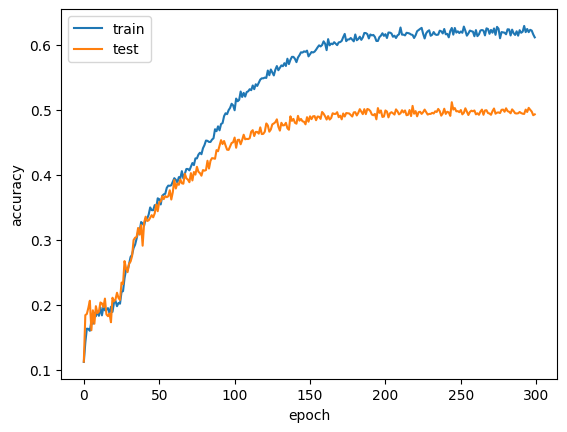

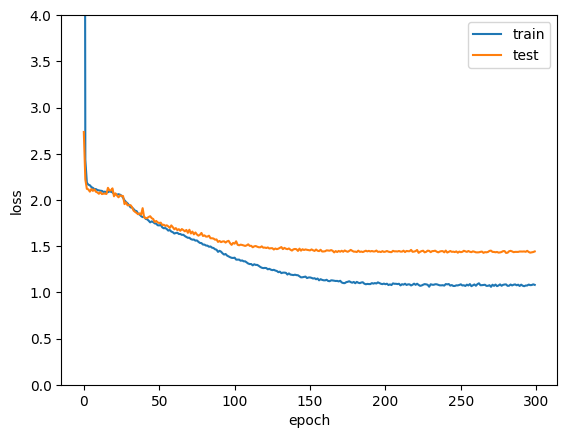

In [11]:
plt.plot(train_accuracy_h, label='train')
plt.plot(test_accuracy_h, label='test')
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend()
plt.show()

plt.plot(train_loss_h, label='train')
plt.plot(test_loss_h, label='test')
plt.ylim((0,4))
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

In [12]:
import pandas as pd
dict = {'train_acc': train_accuracy_h, 'test_acc': test_accuracy_h, 'train_loss': train_loss_h, 'test_loss' : test_loss_h}
df = pd.DataFrame(dict)
df.to_csv('logs/best_resnet_CIFAR10-DVS_ReLU_ReLUmaxpool_128x128_FC2_128x128_pretrained_aug_corrected_trilinear.csv')

In [13]:
df.head()

,train_acc,test_acc,train_loss,test_loss
0,0.112286,0.112667,13.641767,2.735227
1,0.142143,0.184333,2.434911,2.222396
2,0.163429,0.186000,2.187040,2.120445
3,0.163143,0.195333,2.164782,2.113626
4,0.160143,0.206333,2.158775,2.089822


In [14]:
print(df["test_acc"].max())

0.5116666666666667


In [15]:
print(df.to_string())

     train_acc  test_acc  train_loss  test_loss
0     0.112286  0.112667   13.641767   2.735227
1     0.142143  0.184333    2.434911   2.222396
2     0.163429  0.186000    2.187040   2.120445
3     0.163143  0.195333    2.164782   2.113626
4     0.160143  0.206333    2.158775   2.089822
5     0.175143  0.161000    2.139249   2.117920
6     0.170857  0.191667    2.130305   2.097788
7     0.188000  0.171000    2.117433   2.114307
8     0.182571  0.198000    2.117295   2.088395
9     0.189857  0.187333    2.107079   2.081331
10    0.183143  0.189667    2.103521   2.066612
11    0.196286  0.203667    2.099372   2.084497
12    0.183857  0.202333    2.097744   2.063180
13    0.197000  0.196667    2.086101   2.067706
14    0.191571  0.209667    2.089787   2.068418
15    0.192429  0.185333    2.082071   2.064354
16    0.195000  0.182667    2.083499   2.130866
17    0.187000  0.186667    2.092640   2.102756
18    0.197143  0.173333    2.088102   2.103373
19    0.189143  0.211000    2.081710   2